![data-x](https://raw.githubusercontent.com/afo/data-x-plaksha/master/imgsource/dx_logo.png)


# Data-X Notebook: NLP & NLTK
#### Using Natural Language Processing in Python to do sentiment analysis on IMDB movie reviews

Author: Alexander Fred Ojala

Source: 
- https://www.kaggle.com/c/word2vec-nlp-tutorial/data
- https://github.com/rasbt/python-machine-learning-book/tree/master/code
- https://github.com/justmarkham/pycon-2016-tutorial

Code snippets given run on both Python 2.7 and Python 3.x


# Table of Contents:

### - [Part 0: Pre-Setup & Data description](#sec0)
### - [Part 1: Explore the Data](#sec1)
### - [Part 2: NLTK intro (1 review) cleaning, tokenizing, stemming, lemmatization, stopwords](#sec2)
### - [Part 3: Preparing the data set for classification](#sec3)
### - [Part 4: Sentiment Classification w scikit-learn, Feature vectors & Bag of Words model](#sec4)
### - [Appendix: Submitting to Kaggle & possible extensions](#sec5)

<div id='sec0'></div>

# Part 0: Pre-Setup & Data description

In [1]:
#make compatible with Python 2 and Python 3
from __future__ import print_function, division, absolute_import 

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

## Data description

You can download the data (labeledTrainData.tsv.zip) here: https://www.kaggle.com/c/word2vec-nlp-tutorial/data, place it in your working directory & unzip the file. (It is placed in the data folder if you cloned the Github repo)

### Dataset

The labeled training dataset consists of 25,000 IMDB movie reviews. There is also an unlabeled test set with 25,000 IMDB movie reviews. The sentiment of the reviews are binary, meaning an IMDB rating < 5 results in a sentiment score of 0, and a rating >=7 have a sentiment score of 1 (no reviews with score 5 or 6 are included in the analysis). No individual movie has more than 30 reviews.

### File description

* **labeledTrainData** - The labeled training set. The file is tab-delimited and has a header row followed by 25,000 rows containing an id, sentiment, and text for each review. 

* **testData** - The unlabeled test set. 25,000 rows containing an id, and text for each review. 

### Data columns
* **id** - Unique ID of each review
* **sentiment** - Sentiment of the review; 1 for positive reviews and 0 for negative reviews
* **review** - Text of the review


<div id='sec1'></div>

# Part 1: Explore the Data

In [2]:
!head -n4 data/labeledTrainData.tsv
# use bash command to see data set structure

id	sentiment	review
"5814_8"	1	"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual featu

In [3]:
import numpy as np
import pandas as pd   

# Read in the data to a Pandas data frame
# Use header = 0 (first line contains col names)
# use delimiter=\t (columns are separated by tabs)
train = pd.read_csv("data/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("data/testData.tsv", header=0, delimiter="\t", quoting=3)

## Dataset statistics

In [4]:
train.shape

(25000, 3)

In [5]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [6]:
train.info() # no NaN's

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


### 1: How many movie reviews are positive and how many are negative in labeledTrainData.tsv? Do we have balance between the classes?

(25000, 3)

Number of Data Samples for every label output. 1=postive, 2=negative:
1    12500
0    12500
Name: sentiment, dtype: int64


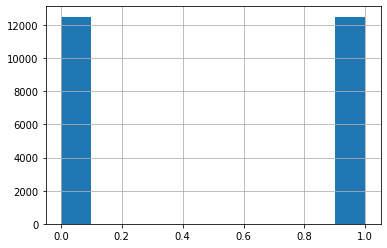

In [7]:
# 1. 
print(train.shape)
print()
print('Number of Data Samples for every label output. 1=postive, 2=negative:')
print(train.sentiment.value_counts())

train.sentiment.hist(); #class balance

### 2: What is the average length of all the reviews (string length)?

In [8]:
# 2. Apply length function to the review column
lengths = train['review'].apply(len)

print('Average character length of the reviews are:')
print (np.mean(lengths))

Average character length of the reviews are:
1329.71056


<div id='sec2'></div>

# Part 2: NLTK intro (1 review) cleaning, tokenizing, stemming, lemmatization, stopwords

Let's explore NLP by looking at the third review in the training data set, i.e. `train['review'][2]`

## DOWNLOAD NLTK CORPORA
Run the below command in an empty cell
```python
nltk.download()
```

Then, download `Corpora / stopwords` and `Models / punkt` and `Models / Averaged Perceptron` and `corpora / wordnet`

In [9]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lizhi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/lizhi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lizhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# import packages
import re
import bs4 as bs
from nltk.tokenize import sent_tokenize # tokenizes sentences
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')

In [11]:
review3 = train['review'][3] # the review used for initial analysis
print(review3)

"It must be assumed that those who praised this film (\"the greatest filmed opera ever,\" didn't I read somewhere?) either don't care for opera, don't care for Wagner, or don't care about anything except their desire to appear Cultured. Either as a representation of Wagner's swan-song, or as a movie, this strikes me as an unmitigated disaster, with a leaden reading of the score matched to a tricksy, lugubrious realisation of the text.<br /><br />It's questionable that people with ideas as to what an opera (or, for that matter, a play, especially one by Shakespeare) is \"about\" should be allowed anywhere near a theatre or film studio; Syberberg, very fashionably, but without the smallest justification from Wagner's text, decided that Parsifal is \"about\" bisexual integration, so that the title character, in the latter stages, transmutes into a kind of beatnik babe, though one who continues to sing high tenor -- few if any of the actors in the film are the singers, and we get a double 

## Clean the review

First we would like to clean up the reviews. As you can see many interviews contain \ characters in front of quotation symobols, "`<br/>` tags, numbers, abbrevations etc.

## 1: Remove all the HTML tags in the third review, by creating a beatifulsoup object and then using the `.text` method. Save results in variable `review3

In [12]:
import bs4 as bs

bs.BeautifulSoup(review3, features='lxml')

<html><body><p>"It must be assumed that those who praised this film (\"the greatest filmed opera ever,\" didn't I read somewhere?) either don't care for opera, don't care for Wagner, or don't care about anything except their desire to appear Cultured. Either as a representation of Wagner's swan-song, or as a movie, this strikes me as an unmitigated disaster, with a leaden reading of the score matched to a tricksy, lugubrious realisation of the text.<br/><br/>It's questionable that people with ideas as to what an opera (or, for that matter, a play, especially one by Shakespeare) is \"about\" should be allowed anywhere near a theatre or film studio; Syberberg, very fashionably, but without the smallest justification from Wagner's text, decided that Parsifal is \"about\" bisexual integration, so that the title character, in the latter stages, transmutes into a kind of beatnik babe, though one who continues to sing high tenor -- few if any of the actors in the film are the singers, and we 

In [13]:
review3 = bs.BeautifulSoup(review3,features='lxml').text # removes HTML tags
print(review3)

"It must be assumed that those who praised this film (\"the greatest filmed opera ever,\" didn't I read somewhere?) either don't care for opera, don't care for Wagner, or don't care about anything except their desire to appear Cultured. Either as a representation of Wagner's swan-song, or as a movie, this strikes me as an unmitigated disaster, with a leaden reading of the score matched to a tricksy, lugubrious realisation of the text.It's questionable that people with ideas as to what an opera (or, for that matter, a play, especially one by Shakespeare) is \"about\" should be allowed anywhere near a theatre or film studio; Syberberg, very fashionably, but without the smallest justification from Wagner's text, decided that Parsifal is \"about\" bisexual integration, so that the title character, in the latter stages, transmutes into a kind of beatnik babe, though one who continues to sing high tenor -- few if any of the actors in the film are the singers, and we get a double dose of Armi

## 2: Import NLTK's sent_tokenizer and count the number of sentences in review 3 
The review should be cleaned from HTML tags. To import sent_tokenizer use: `from nltk.tokenize import sent_tokenize`

In [14]:
from nltk.tokenize import sent_tokenize

print(len(sent_tokenize(review3)))
sent_tokenize(review3) # doesn't really split all sentences

5


['"It must be assumed that those who praised this film (\\"the greatest filmed opera ever,\\" didn\'t I read somewhere?)',
 "either don't care for opera, don't care for Wagner, or don't care about anything except their desire to appear Cultured.",
 'Either as a representation of Wagner\'s swan-song, or as a movie, this strikes me as an unmitigated disaster, with a leaden reading of the score matched to a tricksy, lugubrious realisation of the text.It\'s questionable that people with ideas as to what an opera (or, for that matter, a play, especially one by Shakespeare) is \\"about\\" should be allowed anywhere near a theatre or film studio; Syberberg, very fashionably, but without the smallest justification from Wagner\'s text, decided that Parsifal is \\"about\\" bisexual integration, so that the title character, in the latter stages, transmutes into a kind of beatnik babe, though one who continues to sing high tenor -- few if any of the actors in the film are the singers, and we get a

In [15]:
# Check if it does a better job if we add space after every period
review3 = review3.replace('.','. ')

print(len(sent_tokenize(review3)), end='\n\n') # number of sentences

# print all sentences on a new line
for sent in sent_tokenize(review3):
    print(sent, end='\n\n')

9

"It must be assumed that those who praised this film (\"the greatest filmed opera ever,\" didn't I read somewhere?)

either don't care for opera, don't care for Wagner, or don't care about anything except their desire to appear Cultured.

Either as a representation of Wagner's swan-song, or as a movie, this strikes me as an unmitigated disaster, with a leaden reading of the score matched to a tricksy, lugubrious realisation of the text.

It's questionable that people with ideas as to what an opera (or, for that matter, a play, especially one by Shakespeare) is \"about\" should be allowed anywhere near a theatre or film studio; Syberberg, very fashionably, but without the smallest justification from Wagner's text, decided that Parsifal is \"about\" bisexual integration, so that the title character, in the latter stages, transmutes into a kind of beatnik babe, though one who continues to sing high tenor -- few if any of the actors in the film are the singers, and we get a double dose 

## 3: Remove all punctuation and special characters from the third review.
We can do this using Regular Expression - package `re`. Regular expression define search patterns for text that can be used to search, replace, substitute etc. certain patterns in text data.

We'll use regular expression to only look for alphabetical characters, `[^a-zA-Z]`. Save results in variable `review3`

Intro to Regex: http://www.aivosto.com/vbtips/regex.html

In [16]:
import re

review3 = re.sub('[^a-zA-Z ]' ,'',review3)
print(review3) # remove special characters

It must be assumed that those who praised this film the greatest filmed opera ever didnt I read somewhere either dont care for opera dont care for Wagner or dont care about anything except their desire to appear Cultured  Either as a representation of Wagners swansong or as a movie this strikes me as an unmitigated disaster with a leaden reading of the score matched to a tricksy lugubrious realisation of the text Its questionable that people with ideas as to what an opera or for that matter a play especially one by Shakespeare is about should be allowed anywhere near a theatre or film studio Syberberg very fashionably but without the smallest justification from Wagners text decided that Parsifal is about bisexual integration so that the title character in the latter stages transmutes into a kind of beatnik babe though one who continues to sing high tenor  few if any of the actors in the film are the singers and we get a double dose of Armin Jordan the conductor who is seen as the face 

## 4: Convert all the letters to lower case, split the string so that every word is one element in a list
Note: When we split the strings into words that process is called tokenization.

In [17]:
review3 = review3.lower()
print(review3)

it must be assumed that those who praised this film the greatest filmed opera ever didnt i read somewhere either dont care for opera dont care for wagner or dont care about anything except their desire to appear cultured  either as a representation of wagners swansong or as a movie this strikes me as an unmitigated disaster with a leaden reading of the score matched to a tricksy lugubrious realisation of the text its questionable that people with ideas as to what an opera or for that matter a play especially one by shakespeare is about should be allowed anywhere near a theatre or film studio syberberg very fashionably but without the smallest justification from wagners text decided that parsifal is about bisexual integration so that the title character in the latter stages transmutes into a kind of beatnik babe though one who continues to sing high tenor  few if any of the actors in the film are the singers and we get a double dose of armin jordan the conductor who is seen as the face 

In [18]:
review3_words = review3.split()
print(review3_words[:10]) # tokenize and lower case

['it', 'must', 'be', 'assumed', 'that', 'those', 'who', 'praised', 'this', 'film']


## 5: Stemming
Use NLTK's PorterStemmer (`from nltk.stem import PorterStemmer`). Create a new Porter stemmer (`stemmer = PorterStemmer()`) and run it on every word in `review3_words`, print the results as one string (don't overwrite the `review3_words` variable from 4). 

**What does the PorterStemmer do?**
PorterStemmer tries treating similar words as the same (e.g. give, gives, given = give).

**Stemming (paraphrased from Wiki):** Stemming reduces words to their word stem, base or root form (i.e. similar words, with the same stem, will be interpreted as the same)

In [19]:
from nltk.stem import PorterStemmer

ps = PorterStemmer() #initialize Porter Stemmer object

ps_stems = []
for w in review3_words:
    ps_stems.append(ps.stem(w))

print(' '.join(ps_stems)) # add all the stemmed words to one string

it must be assum that those who prais thi film the greatest film opera ever didnt i read somewher either dont care for opera dont care for wagner or dont care about anyth except their desir to appear cultur either as a represent of wagner swansong or as a movi thi strike me as an unmitig disast with a leaden read of the score match to a tricksi lugubri realis of the text it question that peopl with idea as to what an opera or for that matter a play especi one by shakespear is about should be allow anywher near a theatr or film studio syberberg veri fashion but without the smallest justif from wagner text decid that parsif is about bisexu integr so that the titl charact in the latter stage transmut into a kind of beatnik babe though one who continu to sing high tenor few if ani of the actor in the film are the singer and we get a doubl dose of armin jordan the conductor who is seen as the face but not heard as the voic of amforta and also appear monstrous in doubl exposur as a kind of b

## 6 Part of Speech tagging
Now we want to Part Of Speech (POS) tag the third movie review. We will use POS labeling, also called grammatical tagging. To do this import `from nltk.tag import pos_tag`. 

When you use `pos_tag` on a word it returns a token-tag pair in the form of a tuple. In NLTK's Penn Treebank POS, the abbreviation (tag) for an adjective is JJ and NN for singular nouns. 

Let's count the number of singular nouns (NN) and adjectives (JJ) in `review3_words` using NLTK's pos_tag. A list of the Penn Treebank pos_tag's can be found here: http://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [20]:
from nltk.tag import pos_tag

token_tag = pos_tag(review3_words)
token_tag[:10]

[('it', 'PRP'),
 ('must', 'MD'),
 ('be', 'VB'),
 ('assumed', 'VBN'),
 ('that', 'IN'),
 ('those', 'DT'),
 ('who', 'WP'),
 ('praised', 'VBD'),
 ('this', 'DT'),
 ('film', 'NN')]

In [21]:
# Cell that count nouns (NN) and adjectives (JJ) in review3
NN_count = 0
JJ_count = 0

for pair in token_tag:
    tag = pair[1]
    if tag == 'JJ':
        JJ_count+=1
    elif tag == 'NN':
        NN_count+=1
print('Number of nouns:', NN_count)
print('Number of adjectives:', JJ_count)

Number of nouns: 91
Number of adjectives: 32


## 7. Lemmatizing
An even more sophisticated operation than stemming using the PorterStemmer is called lemmatizing. 

Lemmatizing, in contrast to stemming, does not create non-existent words and converts words to their synonyms. In order to use lemmatizing we need to define the wordnet POS tag. A function that takes in a POS Penn Treebank tag and converts it to a wordnet tag and then lemmatizes words in a string has been given written below. 

**Lemmatization (paraphrased from Wiki):** Lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

We can use this to print the lemmatized third movie review.

See more about stemming and lemmatization: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [22]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

In [23]:
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

wnl_stems = []
for pair in token_tag:
    res = wnl.lemmatize(pair[0],pos=get_wordnet_pos(pair[1]))
    wnl_stems.append(res)

print(' '.join(wnl_stems))

it must be assume that those who praise this film the great filmed opera ever didnt i read somewhere either dont care for opera dont care for wagner or dont care about anything except their desire to appear cultured either a a representation of wagner swansong or a a movie this strike me a an unmitigated disaster with a leaden reading of the score match to a tricksy lugubrious realisation of the text it questionable that people with idea a to what an opera or for that matter a play especially one by shakespeare be about should be allow anywhere near a theatre or film studio syberberg very fashionably but without the small justification from wagner text decide that parsifal be about bisexual integration so that the title character in the latter stage transmute into a kind of beatnik babe though one who continue to sing high tenor few if any of the actor in the film be the singer and we get a double dose of armin jordan the conductor who be see a the face but not heard a the voice of amf

## 8. StopWords

Lastly we will remove common words that don't carry much information. These are called stopwords. 

In English they could for example be 'am', 'are', 'and', 'the' etc. 

To import NLTK's list of stopwords you need to download the stopword corpora (`import nltk` and then `nltk.download()` if you don't have it). 

When that is done run `from nltk.corpus import stopwords` and create a variable for English stopwords with `eng_stopwords = stopwords.words('english')`. Use the list of English stopwords to remove all the stopwords from your list of words in the third movie review, i.e. `review3_words`. Print `review3_words` without stopwords, count the number of stopwords removed and print them as well.

In [24]:
from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')
print(eng_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [25]:
review3_wo_stopwords = [w for w in review3_words if not w in stopwords.words("english")]
removed_stopwords = [w for w in review3_words if w in stopwords.words("english")]

print('REVIEW WITHOUT STOPWORDS:')
print(' '.join(review3_wo_stopwords))
print()
print('Stop words removed', removed_stopwords)
print()
print('NUMBER OF STOPWORDS REMOVED:',len(removed_stopwords))

REVIEW WITHOUT STOPWORDS:
must assumed praised film greatest filmed opera ever didnt read somewhere either dont care opera dont care wagner dont care anything except desire appear cultured either representation wagners swansong movie strikes unmitigated disaster leaden reading score matched tricksy lugubrious realisation text questionable people ideas opera matter play especially one shakespeare allowed anywhere near theatre film studio syberberg fashionably without smallest justification wagners text decided parsifal bisexual integration title character latter stages transmutes kind beatnik babe though one continues sing high tenor actors film singers get double dose armin jordan conductor seen face heard voice amfortas also appears monstrously double exposure kind batonzilla conductor ate monsalvat playing good friday music way transcendant loveliness nature represented scattering shopworn flaccid crocuses stuck illlaid turf expedient baffles theatre sometimes piece imperfections tho

<div id='sec3'></div>

# Part 3: Preparing the dataset for classification

In this part we'll put everything that we've learned so far together. This so that we can use our reviews to make accurate predicitons on their sentiment.

## 1. Review cleaning function

We'll create a function called `review_cleaner` that reads in a review and:

- Removes HTML tags (using beautifulsoup)
- **Extract emoticons (emotion symbols, aka smileys :D )**
- Removes non-letters (using regular expression)
- Converts all words to lowercase letters and tokenizes them (using .split() method on the review strings, so that every word in the review is an element in a list)
- Removes all the English stopwords from the list of movie review words
- Join the words back into one string seperated by space, append the emoticons to the end

**NOTE: Transform the list of stopwords to a set before removing the stopwords. I.e. assign `eng_stopwords = set(stopwords.words("english"))`. Use the set to look up stopwords. This will speed up the computations A LOT (Python is much quicker when searching a set than a list).**

In [26]:
def review_cleaner(review):
    '''
    Clean and preprocess a review.
    
    1. Remove HTML tags
    2. Extract emoticons
    3. Use regex to remove all special characters (only keep letters)
    4. Make strings to lower case and tokenize / word split reviews
    5. Remove English stopwords
    6. Rejoin to one string
    '''
    
    #1. Remove HTML tags
    review = bs.BeautifulSoup(review).text
    
    #2. Use regex to find emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', review)
    
    #3. Remove punctuation
    review = re.sub("[^a-zA-Z]", " ",review)
    
    #4. Tokenize into words (all lower case)
    review = review.lower().split()
    
    #5. Remove stopwords
    eng_stopwords = set(stopwords.words("english"))
    review = [w for w in review if not w in eng_stopwords]
    
    #6. Join the review to one sentence
    review = ' '.join(review+emoticons)
    # add emoticons to the end

    return(review)

In [27]:
review_cleaner(train['review'][3])

'must assumed praised film greatest filmed opera ever read somewhere either care opera care wagner care anything except desire appear cultured either representation wagner swan song movie strikes unmitigated disaster leaden reading score matched tricksy lugubrious realisation text questionable people ideas opera matter play especially one shakespeare allowed anywhere near theatre film studio syberberg fashionably without smallest justification wagner text decided parsifal bisexual integration title character latter stages transmutes kind beatnik babe though one continues sing high tenor actors film singers get double dose armin jordan conductor seen face heard voice amfortas also appears monstrously double exposure kind batonzilla conductor ate monsalvat playing good friday music way transcendant loveliness nature represented scattering shopworn flaccid crocuses stuck ill laid turf expedient baffles theatre sometimes piece imperfections thoughts think syberberg splice parsifal gurneman

## 2. Create original, Porter Stemmed, and Lemmatized data sets
    
**Create three lists `review_clean_original`, `review_clean_ps` and `review_clean_wnl`.**

- `review_clean_original` contains all the reviews from the train DataFrame, that have been cleaned by the function `review_cleaner` defined above.

- `review_clean_ps` applies the PorterStemmer to the reviews in `review_clean_original`. **Note:** NLTK version 3.2.2 crashes when trying to use the PorterStemming on the string 'oed' (known bug). Therefore, use an if statement to skip just that specific string/word.

- `review_clean_wnl` contains words that have been lemmatized using NLTK's WordNetLemmatizer on the words in the list `review_clean_original`.
    
**Note: This can take more than 10minutes to run on a laptop**

In [28]:
%%time

num_reviews = len(train['review'])

review_clean_original = []

for i in range(0,num_reviews):
    if( (i+1)%500 == 0 ):
        # print progress
        print("Done with %d reviews" %(i+1)) 
    review_clean_original.append(review_cleaner(train['review'][i]))

Done with 500 reviews
Done with 1000 reviews
Done with 1500 reviews
Done with 2000 reviews
Done with 2500 reviews
Done with 3000 reviews
Done with 3500 reviews
Done with 4000 reviews
Done with 4500 reviews
Done with 5000 reviews
Done with 5500 reviews
Done with 6000 reviews
Done with 6500 reviews
Done with 7000 reviews
Done with 7500 reviews
Done with 8000 reviews
Done with 8500 reviews
Done with 9000 reviews
Done with 9500 reviews
Done with 10000 reviews
Done with 10500 reviews
Done with 11000 reviews
Done with 11500 reviews
Done with 12000 reviews
Done with 12500 reviews
Done with 13000 reviews
Done with 13500 reviews
Done with 14000 reviews
Done with 14500 reviews
Done with 15000 reviews
Done with 15500 reviews
Done with 16000 reviews
Done with 16500 reviews
Done with 17000 reviews
Done with 17500 reviews
Done with 18000 reviews
Done with 18500 reviews
Done with 19000 reviews
Done with 19500 reviews
Done with 20000 reviews
Done with 20500 reviews
Done with 21000 reviews
Done with 21

In [29]:
review_clean_original[3]

'must assumed praised film greatest filmed opera ever read somewhere either care opera care wagner care anything except desire appear cultured either representation wagner swan song movie strikes unmitigated disaster leaden reading score matched tricksy lugubrious realisation text questionable people ideas opera matter play especially one shakespeare allowed anywhere near theatre film studio syberberg fashionably without smallest justification wagner text decided parsifal bisexual integration title character latter stages transmutes kind beatnik babe though one continues sing high tenor actors film singers get double dose armin jordan conductor seen face heard voice amfortas also appears monstrously double exposure kind batonzilla conductor ate monsalvat playing good friday music way transcendant loveliness nature represented scattering shopworn flaccid crocuses stuck ill laid turf expedient baffles theatre sometimes piece imperfections thoughts think syberberg splice parsifal gurneman

In [30]:
%%time
# Porter stemming on the results in review_clean_original

review_clean_ps = []

ps = PorterStemmer()


for i in range(0,num_reviews):
    if( (i+1)%500 == 0 ):
        # print progress
        print("Done with %d reviews" %(i+1)) 
    ps_stems = []
    for w in review_clean_original[i].split():
        if w == 'oed':
            continue
        ps_stems.append(ps.stem(w))
    
    review_clean_ps.append(' '.join(ps_stems))

Done with 500 reviews
Done with 1000 reviews
Done with 1500 reviews
Done with 2000 reviews
Done with 2500 reviews
Done with 3000 reviews
Done with 3500 reviews
Done with 4000 reviews
Done with 4500 reviews
Done with 5000 reviews
Done with 5500 reviews
Done with 6000 reviews
Done with 6500 reviews
Done with 7000 reviews
Done with 7500 reviews
Done with 8000 reviews
Done with 8500 reviews
Done with 9000 reviews
Done with 9500 reviews
Done with 10000 reviews
Done with 10500 reviews
Done with 11000 reviews
Done with 11500 reviews
Done with 12000 reviews
Done with 12500 reviews
Done with 13000 reviews
Done with 13500 reviews
Done with 14000 reviews
Done with 14500 reviews
Done with 15000 reviews
Done with 15500 reviews
Done with 16000 reviews
Done with 16500 reviews
Done with 17000 reviews
Done with 17500 reviews
Done with 18000 reviews
Done with 18500 reviews
Done with 19000 reviews
Done with 19500 reviews
Done with 20000 reviews
Done with 20500 reviews
Done with 21000 reviews
Done with 21

In [31]:
review_clean_ps[3]

'must assum prais film greatest film opera ever read somewher either care opera care wagner care anyth except desir appear cultur either represent wagner swan song movi strike unmitig disast leaden read score match tricksi lugubri realis text question peopl idea opera matter play especi one shakespear allow anywher near theatr film studio syberberg fashion without smallest justif wagner text decid parsif bisexu integr titl charact latter stage transmut kind beatnik babe though one continu sing high tenor actor film singer get doubl dose armin jordan conductor seen face heard voic amforta also appear monstrous doubl exposur kind batonzilla conductor ate monsalvat play good friday music way transcend loveli natur repres scatter shopworn flaccid crocus stuck ill laid turf expedi baffl theatr sometim piec imperfect thought think syberberg splice parsif gurnemanz mountain pastur lush provid juli andrew sound music sound hard endur high voic trumpet particular possess aural glare add anoth s

In [32]:
%%time
# Lemmatizer

review_clean_wnl = []

wnl = WordNetLemmatizer()

for i in range(0,num_reviews):
    if( (i+1)%500 == 0 ):
        # print progress
        print("Done with %d reviews" %(i+1)) 
    
    wnl_stems = []
    token_tag = pos_tag(review_clean_original[i].split())
    for pair in token_tag:
        res = wnl.lemmatize(pair[0],pos=get_wordnet_pos(pair[1]))
        wnl_stems.append(res)

    review_clean_wnl.append(' '.join(wnl_stems))

Done with 500 reviews
Done with 1000 reviews
Done with 1500 reviews
Done with 2000 reviews
Done with 2500 reviews
Done with 3000 reviews
Done with 3500 reviews
Done with 4000 reviews
Done with 4500 reviews
Done with 5000 reviews
Done with 5500 reviews
Done with 6000 reviews
Done with 6500 reviews
Done with 7000 reviews
Done with 7500 reviews
Done with 8000 reviews
Done with 8500 reviews
Done with 9000 reviews
Done with 9500 reviews
Done with 10000 reviews
Done with 10500 reviews
Done with 11000 reviews
Done with 11500 reviews
Done with 12000 reviews
Done with 12500 reviews
Done with 13000 reviews
Done with 13500 reviews
Done with 14000 reviews
Done with 14500 reviews
Done with 15000 reviews
Done with 15500 reviews
Done with 16000 reviews
Done with 16500 reviews
Done with 17000 reviews
Done with 17500 reviews
Done with 18000 reviews
Done with 18500 reviews
Done with 19000 reviews
Done with 19500 reviews
Done with 20000 reviews
Done with 20500 reviews
Done with 21000 reviews
Done with 21

In [33]:
review_clean_wnl[3]

'must assume praised film great film opera ever read somewhere either care opera care wagner care anything except desire appear culture either representation wagner swan song movie strike unmitigated disaster leaden reading score match tricksy lugubrious realisation text questionable people idea opera matter play especially one shakespeare allow anywhere near theatre film studio syberberg fashionably without small justification wagner text decide parsifal bisexual integration title character latter stag transmutes kind beatnik babe though one continue sing high tenor actor film singer get double dose armin jordan conductor see face heard voice amfortas also appear monstrously double exposure kind batonzilla conductor ate monsalvat play good friday music way transcendant loveliness nature represent scatter shopworn flaccid crocus stick ill lay turf expedient baffle theatre sometimes piece imperfection thought think syberberg splice parsifal gurnemanz mountain pasture lush provide julie 

<div id='sec4'></div>

# Part 4: Sentiment Classification w scikit-learn, Feature vectors & Bag of Words model

### Bag of Words: Explanation

Derived from source: https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words

We will now use scikit-learn to create numeric representations of the words in the reviews, using a method called Bag of Words. You can see this as learning a vocabulary from all the reviews and counting how many times a word appears in the reviews. For example, if we have two sentences:

**Sentence 1:** "cool students study cool data science"

**Sentence 2:** "to know data science study data science"

The vocabulary of these two sentences can be summarized in a dictionary:

    { cool, students, study, data, science, to, know }

The bags of words count the number of times each word occur in a sentence. In Sentence 1, "cool" appears twice, and "students", "study", "data", and "science" appear once. The feature vector for Sentence 1 is:

    Sentence 1: { 2, 1, 1, 1, 1, 0, 0 }

    Sentence 2: { 0, 0, 1, 2, 2, 1, 1 }


The `fit` method in scikit-learns `CountVectorizer` creates the vocabulary of the bag-of-words model and fits the function to the data set you pass in.

The `transform` method in `CountVectorizer` transforms text input to a feature matrix, where the rows are the document inputs and the columns are the words / feature in the vocabulary.

In [34]:
## Example code BoW

from sklearn.feature_extraction.text import CountVectorizer

sent1 = "cool students study cool data science"
sent2 = "to know data science study data science"

vect = CountVectorizer() #instantiate

sents = np.array([sent1,sent2])

vect.fit(sents);


In [35]:
print('Total number of words in the vocabulary (and position in feature matrix):\n')
print(vect.vocabulary_)

# vocabulary for the BoW model is stored in a dictionary

Total number of words in the vocabulary (and position in feature matrix):

{'cool': 0, 'students': 4, 'study': 5, 'data': 1, 'science': 3, 'to': 6, 'know': 2}


In [36]:
# Transform to get feature vectors

bag = vect.transform(sents)

bag.toarray()

# the rows corresponds to the sentences 

array([[2, 1, 0, 1, 1, 1, 0],
       [0, 2, 1, 2, 0, 1, 1]])

In [37]:
vect.get_feature_names() # stored in the right places

['cool', 'data', 'know', 'science', 'students', 'study', 'to']

In [38]:
# Put it in a DataFrame for interpretability

pd.DataFrame(bag.toarray(), columns=vect.get_feature_names(), index=[sent1,sent2])

# the number in the DataFrame is called Raw Term frequency raw term frequencies: 
# tf (t,d)—the number of times a term t occurs in a document d.

,cool,data,know,science,students,study,to
cool students study cool data science,2,1,0,1,1,1,0
to know data science study data science,0,2,1,2,0,1,1


# Applying this strategy to the IMDB movie reviews

The movie review data contains a lot of words. To limit the analysis we use the 5000 most frequent words from the cleaned reviews. To extract the bag of words features we will use scitkit-learn.

The training data will be created by the `CountVectorizer` function from scikit-learn, and the training array will have 25000 rows (one for each review) and 5000 features (one for each vocabulary word).

CountVectorizer can automatically handle text cleaning, but here we specify `None`, instead we did a step-by-step cleaning of the data in the earlier problems.

#### Random Forest for review sentiment classification

First split up the data set so that 80% are used as training samples (the first 20000 reviews and their sentiment) and 20% are used as validation samples (the last 5000 reviews and their sentiment). Use Random Forest to do numeric training on the features for the training samples from the Bag of Words and their respective sentiment labels for each review / feature vector. The number of trees is set to 50 as a default value.


## Classify IMDB movie review dataset

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics # for confusion matrix, accuracy score etc
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(review_clean_original, train['sentiment'],
                                                    random_state=0, test_size=.2)


# CountVectorizer can actucally handle a lot of the preprocessing for us
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)

In [40]:
%%time
# Transform the text data to feature
# Only fit training data (to mimic real world)

vectorizer.fit(X_train)

CPU times: user 1.62 s, sys: 41.7 ms, total: 1.66 s
Wall time: 1.66 s


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=5000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [41]:
# Check that it worked, 
# now we have fitted a model that can transform features
# to sparse matrix representation

print(vectorizer.get_feature_names()[:10])

['abandoned', 'abc', 'abilities', 'ability', 'able', 'abraham', 'absence', 'absent', 'absolute', 'absolutely']


In [42]:
train_bag = vectorizer.transform(X_train) #transform to a feature matrix
test_bag = vectorizer.transform(X_test)

In [43]:
print(train_bag.toarray().shape) # 20,000 reviews, 2,000 feartures. just as expected
print(test_bag.toarray().shape)

(20000, 5000)
(5000, 5000)


In [44]:
type(train_bag)

scipy.sparse.csr.csr_matrix

In [45]:
print(train_bag)

  (0, 37)	1
  (0, 41)	1
  (0, 46)	1
  (0, 51)	1
  (0, 58)	1
  (0, 103)	1
  (0, 126)	1
  (0, 142)	2
  (0, 145)	1
  (0, 147)	1
  (0, 162)	1
  (0, 194)	2
  (0, 205)	1
  (0, 265)	1
  (0, 286)	1
  (0, 315)	1
  (0, 327)	2
  (0, 335)	1
  (0, 368)	1
  (0, 395)	1
  (0, 411)	1
  (0, 436)	1
  (0, 475)	1
  (0, 480)	1
  (0, 485)	1
  :	:
  (19999, 3301)	1
  (19999, 3385)	1
  (19999, 3551)	1
  (19999, 3643)	1
  (19999, 3762)	1
  (19999, 3824)	2
  (19999, 3877)	2
  (19999, 3885)	1
  (19999, 3886)	2
  (19999, 3914)	2
  (19999, 3970)	2
  (19999, 4057)	1
  (19999, 4095)	1
  (19999, 4102)	1
  (19999, 4191)	1
  (19999, 4248)	1
  (19999, 4279)	1
  (19999, 4473)	1
  (19999, 4474)	1
  (19999, 4619)	1
  (19999, 4699)	1
  (19999, 4766)	1
  (19999, 4811)	1
  (19999, 4853)	1
  (19999, 4892)	1


## Classify with Random Forest model

* Fit a Random Forest model to our bagged data set in order to do the sentiment analysis on `review_clean_original` and print the **validation accuracy** by using `forest.predict(test_bag)` and then comparing the resulting sentiment predictions with the ones stored in `y_test`.

*This can take 2-3 mins to run*

In [46]:
from sklearn.ensemble import RandomForestClassifier

## Initialize a Random Forest classifier with 50 trees
# hyperparameter n_estimators always set in instantiation

forest = RandomForestClassifier(n_estimators = 50) 

In [47]:
%%time
# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the target variable

forest = forest.fit(train_bag, y_train) # can take 20 seconds to run

CPU times: user 16.1 s, sys: 20.8 ms, total: 16.1 s
Wall time: 16.1 s


In [48]:
# Make predictions

train_predictions = forest.predict(train_bag)
valid_predictions = forest.predict(test_bag)

## Accuracy

In [49]:
metrics.accuracy_score(y_train,train_predictions) # 100% training accuracy

1.0

In [50]:
metrics.accuracy_score(y_test,valid_predictions) # 83% test

0.8384

In [51]:
# Confusion matrix
# Is the number of False Positives and True negatives approx 50/50?
metrics.confusion_matrix(y_test,valid_predictions)

array([[2162,  386],
       [ 422, 2030]])

In [52]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test,valid_predictions).ravel()
fp, fn

(386, 422)

In [53]:
valid_predictions==1

array([ True,  True,  True, ...,  True, False,  True])

In [54]:
# What are the characteristics of False Positives for example?
# Good practice when doing analysis

df_test = pd.DataFrame(X_test)
fp_test = df_test[(y_test.values==0) & (valid_predictions==1)]
fp_test

,0
0,vaguely remember ben sci fi fandom days severa...
2,natural born killers cinema cut r director cut...
15,another example sucky sequel great movie highl...
28,find sad christians one feel must make movies ...
33,upon time science fiction author named h beam ...
...,...
4936,curious watch movie lot people seem excited al...
4975,good movies keep front tv dying see result mov...
4980,first saw film impressive one seen friends dvd...
4982,weak sequel lacks interest light touch magnifi...


In [55]:
print(fp_test.iloc[3, 0])

find sad christians one feel must make movies like left behind much better stories tell preachy disappointed film aspiring filmmaker believes christ see film perfect example going career film


In [56]:
index = review_clean_original.index(fp_test.iloc[3, 0])
print(train.review[index])

"I find it sad that Christians (and I am one) feel that we must make movies like \"Left Behind.\" We have much better stories to tell that don't have to be so preachy. I was very disappointed with this film. As an aspiring filmmaker who believes in Christ, I see this film as the perfect example for what I am not going to do with my career in film."


## Feature importances

In [57]:
importances = forest.feature_importances_
# returns relative importance of all features.
# they are in the order of the columns
print(importances)

[1.12341713e-04 1.00155088e-04 6.50244400e-05 ... 2.29656218e-04
 1.76459703e-04 8.02146260e-05]


In [58]:
# sort importance scores
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
top_10 = indices[:10]

# Get top ten features
print([vectorizer.get_feature_names()[ind] for ind in top_10])

Feature ranking:
['worst', 'bad', 'great', 'awful', 'waste', 'excellent', 'wonderful', 'boring', 'terrible', 'best']


# Put everything together in a function

In [59]:
from sklearn.ensemble import RandomForestClassifier

# put everything together in a function

def predict_sentiment(cleaned_reviews, y=train["sentiment"]):

    print("Creating the bag of words model!\n")
    # CountVectorizer" is scikit-learn's bag of words tool, here we show more keywords 
    vectorizer = CountVectorizer(analyzer = "word",
                                 tokenizer = None,
                                 preprocessor = None,
                                 stop_words = None,
                                 max_features = 2000) 
    
    X_train, X_test, y_train, y_test = train_test_split(cleaned_reviews, y, random_state=0, test_size=.2)

    # Then we use fit_transform() to fit the model / learn the vocabulary,
    # then transform the data into feature vectors.
    # The input should be a list of strings. .toarraty() converts to a numpy array
    
    train_bag = vectorizer.fit_transform(X_train).toarray()
    test_bag = vectorizer.transform(X_test).toarray()

    # You can extract the vocabulary created by CountVectorizer
    # by running print(vectorizer.get_feature_names())


    print("Training the random forest classifier!\n")
    # Initialize a Random Forest classifier with 75 trees
    forest = RandomForestClassifier(n_estimators = 50) 

    # Fit the forest to the training set, using the bag of words as 
    # features and the sentiment labels as the target variable
    forest = forest.fit(train_bag, y_train)


    train_predictions = forest.predict(train_bag)
    test_predictions = forest.predict(test_bag)
    
    train_acc = metrics.accuracy_score(y_train, train_predictions)
    valid_acc = metrics.accuracy_score(y_test, test_predictions)
    print("The training accuracy is: ", train_acc, "\n", "The validation accuracy is: ", valid_acc)
    
    return(forest,vectorizer)

## Compare Original cleaned to lemmatized and stemmed data set

Now carry out the same analysis as above but on the `review_clean_ps` and `review_clean_wnl`. 

What data preprocessing strategy worked the best? Why do you think that is? (Feel free to change the number of features extracted in the bag of words model and the number of trees in the random forest model (i.e. the hyperparameters in our model), to see how it effects your accuracy. Is the accuracy better or worse?

In [60]:
%%time

print('Original Reviews')
forest1,vec1 = predict_sentiment(review_clean_original)
print('Porter Stemmer')
forest2,vec2 = predict_sentiment(review_clean_ps)
print('Lemmatizing')
forest3,vec3 = predict_sentiment(review_clean_wnl)


# It  seems like Porter Stemmer and Lemmatizing does not effect the results as much as we thought
# This is just what Sebastian Raschka points out in his book Python Machine Learning:

'''
The Porter stemming algorithm is probably the oldest and simplest
stemming algorithm. Other popular stemming algorithms include the
newer Snowball stemmer (Porter2 or "English" stemmer) or the Lancaster
stemmer (Paice-Husk stemmer), which is faster but also more aggressive
than the Porter stemmer. Those alternative stemming algorithms are also
available through the NLTK package (http://www.nltk.org/api/
nltk.stem.html).

While stemming can create non-real words, such as thu, (from thus) as
shown in the previous example, a technique called lemmatization aims to
obtain the canonical (grammatically correct) forms of individual words—
the so-called lemmas. However, lemmatization is computationally more
diffcult and expensive compared to stemming and, in practice, it has
been observed that stemming and lemmatization have little impact on the
performance of text classifcation (Michal Toman, Roman Tesar, and Karel
Jezek. Infuence of word normalization on text classifcation. Proceedings of
InSciT, pages 354–358, 2006).
'''

Original Reviews
Creating the bag of words model!

Training the random forest classifier!

The training accuracy is:  1.0 
 The validation accuracy is:  0.8308
Porter Stemmer
Creating the bag of words model!

Training the random forest classifier!

The training accuracy is:  1.0 
 The validation accuracy is:  0.8334
Lemmatizing
Creating the bag of words model!

Training the random forest classifier!

The training accuracy is:  1.0 
 The validation accuracy is:  0.8272
CPU times: user 45.6 s, sys: 843 ms, total: 46.4 s
Wall time: 46.5 s


'\nThe Porter stemming algorithm is probably the oldest and simplest\nstemming algorithm. Other popular stemming algorithms include the\nnewer Snowball stemmer (Porter2 or "English" stemmer) or the Lancaster\nstemmer (Paice-Husk stemmer), which is faster but also more aggressive\nthan the Porter stemmer. Those alternative stemming algorithms are also\navailable through the NLTK package (http://www.nltk.org/api/\nnltk.stem.html).\n\nWhile stemming can create non-real words, such as thu, (from thus) as\nshown in the previous example, a technique called lemmatization aims to\nobtain the canonical (grammatically correct) forms of individual words—\nthe so-called lemmas. However, lemmatization is computationally more\ndiffcult and expensive compared to stemming and, in practice, it has\nbeen observed that stemming and lemmatization have little impact on the\nperformance of text classifcation (Michal Toman, Roman Tesar, and Karel\nJezek. Infuence of word normalization on text classifcation. 

In [61]:
vec1.get_feature_names()

['ability',
 'able',
 'absolute',
 'absolutely',
 'absurd',
 'academy',
 'accent',
 'accept',
 'accident',
 'according',
 'accurate',
 'across',
 'act',
 'acted',
 'acting',
 'action',
 'actions',
 'actor',
 'actors',
 'actress',
 'actresses',
 'acts',
 'actual',
 'actually',
 'adam',
 'adaptation',
 'add',
 'added',
 'addition',
 'adds',
 'admit',
 'adult',
 'adults',
 'adventure',
 'advice',
 'affair',
 'afraid',
 'african',
 'age',
 'aged',
 'agent',
 'ages',
 'ago',
 'agree',
 'ahead',
 'air',
 'al',
 'alan',
 'albert',
 'alex',
 'alien',
 'alive',
 'allen',
 'allow',
 'allowed',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'amazing',
 'america',
 'american',
 'americans',
 'among',
 'amount',
 'amusing',
 'ancient',
 'andy',
 'angry',
 'animal',
 'animals',
 'animated',
 'animation',
 'anime',
 'ann',
 'anne',
 'annoying',
 'another',
 'answer',
 'anthony',
 'anti',
 'anybody',
 'anymore',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 

In [62]:
for vec, model in zip([vec1, vec2, vec3], [forest1, forest2, forest3]):
    print('TOP TEN IMPORTANT FEATURES:')
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_10 = indices[:10]
    feature_names = vec.get_feature_names()
    print([feature_names[ind] for ind in top_10])

TOP TEN IMPORTANT FEATURES:
['bad', 'worst', 'great', 'waste', 'awful', 'excellent', 'terrible', 'boring', 'best', 'nothing']
TOP TEN IMPORTANT FEATURES:
['bad', 'worst', 'wast', 'great', 'aw', 'love', 'excel', 'bore', 'best', 'stupid']
TOP TEN IMPORTANT FEATURES:
['bad', 'waste', 'great', 'awful', 'excellent', 'love', 'wonderful', 'terrible', 'bore', 'nothing']


<div id='sec5'></div>

# Appendix Kaggle submission code

In [63]:
# If you want to submit to Kaggle
test = pd.read_csv("data/testData.tsv", header=0, delimiter="\t", quoting=3)

# Verify that there are 25,000 rows and 2 columns
print(test.shape)

# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
clean_test_reviews = [] 

print("Cleaning and parsing the test set movie reviews...\n")
for i in range(0, num_reviews):
    if( (i+1) % 1000 == 0 ):
        print("Review %d of %d\n" % (i+1, num_reviews))
    clean_review = review_cleaner( test["review"][i] )
    clean_test_reviews.append( clean_review )



# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "BoW_results.csv", index=False, quoting=3 )

(25000, 2)
Cleaning and parsing the test set movie reviews...

Review 1000 of 25000

Review 2000 of 25000

Review 3000 of 25000

Review 4000 of 25000

Review 5000 of 25000

Review 6000 of 25000

Review 7000 of 25000

Review 8000 of 25000

Review 9000 of 25000

Review 10000 of 25000

Review 11000 of 25000

Review 12000 of 25000

Review 13000 of 25000

Review 14000 of 25000

Review 15000 of 25000

Review 16000 of 25000

Review 17000 of 25000

Review 18000 of 25000

Review 19000 of 25000

Review 20000 of 25000

Review 21000 of 25000

Review 22000 of 25000

Review 23000 of 25000

Review 24000 of 25000

Review 25000 of 25000

